![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Exercise 5 - RNN </center>
### <center> Many to One RNN </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/Exercises/Ex5/Exercise05_RNN.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
if 'google.colab' in str(get_ipython()):
    !npx degit FixelAlgorithmsTeam/FixelCourses/DeepLearningMethods/Exercises/Ex5/DeepLearningFramework ./DeepLearningFramework

In [4]:
import numpy             as np
import matplotlib.pyplot as plt

import torch
import torch.nn    as nn
import torch.optim as optim
import torchtext

from torchtext.vocab import Vocab

### Exercise:
Get above 80% accuracy on the `Names` dataset.

### Load the data:

In [5]:
mData   = np.load('NamesData.npy')
lNames  = mData[:,0]
lLabels = mData[:,1]
N       = mData.shape[0]

vIdx    = np.random.randint(0, N, (5,))
print(f'Some names : {[f"{lNames [idx]:13}" for idx in vIdx]}')
print(f'Some labels: {[f"{lLabels[idx]:13}" for idx in vIdx]}')

Some names : ['Djumabaev    ', 'You          ', 'Viner        ', 'Baidyuk      ', 'Draper       ']
Some labels: ['Russian      ', 'Korean       ', 'Russian      ', 'Russian      ', 'English      ']


#### Build the vocabulary:

In [6]:
from string          import ascii_letters
from torchtext.vocab import build_vocab_from_iterator

oVocab   = build_vocab_from_iterator([c for c in ascii_letters])
nLetters = len(oVocab)

print (f'Number of letter: {len(oVocab)}')
oVocab(['A', 'B', 'C', 'a', 'b', 'z'])

Number of letter: 52


[0, 1, 2, 26, 27, 51]

#### Label encoder:

In [7]:
from sklearn.preprocessing import LabelEncoder

oLabelEncoder = LabelEncoder().fit(lLabels)
nLabels       = len(oLabelEncoder.classes_)

print(f'Number of labels: {nLabels}'               )
print(f'Labels:         \n{oLabelEncoder.classes_}')

Number of labels: 18
Labels:         
['Arabic' 'Chinese' 'Czech' 'Dutch' 'English' 'French' 'German' 'Greek'
 'Irish' 'Italian' 'Japanese' 'Korean' 'Polish' 'Portuguese' 'Russian'
 'Scottish' 'Spanish' 'Vietnamese']


In [8]:
oLabelEncoder.transform(['Arabic', 'Czech'])

array([0, 2])

#### String to tensor:

In [9]:
def Name2Tensor(name):
    return torch.tensor(oVocab(list(name)))

def Tensor2Name(vName):
    return ''.join([oVocab.get_itos()[e] for e in vName])

name  = 'Jones'
vName = Name2Tensor(name)

Name2Tensor(name), Tensor2Name(vName)

(tensor([ 9, 40, 39, 30, 44]), 'Jones')

#### Dataset:
`__getitem__`:
* `vName` is the tensor version of the string `name`.
* `y` is the integer represents the class `label`.

In [10]:
class NameDataset(torch.utils.data.Dataset):
    def __init__(self, lNames, lLabels):
        self.lNames  = lNames
        self.lLabels = lLabels
        
    def __len__(self): 
        return len(lNames)
    
    def __getitem__(self, idx):
        # calculate tensor version of name
        # vName = lNames[idx]
        # error: 
        # list indices must be integers or slices, not str
        vName = Name2Tensor(self.lNames[idx]) 
    

        # integer represents the class `label`
        #y = lLabels[idx]
        ## error: y contains previously unseen labels: ['Vietnamese']

        label = self.lLabels[idx]
        
        # y = oLabelEncoder.transform(label)
        ## error: y should be a 1d array, got an array of shape () instead.
        
        y = oLabelEncoder.transform([label])
        ## error: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
        
        # transform returns an array, we only need the first one
        y = y[0]

        return vName, y
    
oDataset = NameDataset(lNames, lLabels)
vName, y = oDataset[20001]

Tensor2Name(vName), oLabelEncoder.inverse_transform([y])

('Nguyen', array(['Vietnamese'], dtype='<U19'))

In [11]:
from torch.utils.data import random_split

N                   = mData.shape[0]
nTrain              = 15000
nTest               = N - nTrain
oTrainSet, oTestSet = random_split(oDataset, [nTrain, nTest], generator=torch.Generator().manual_seed(42))

len(oTrainSet), len(oTestSet)

(15000, 5074)

#### Data loader:
* `vY` is a tensor (`dtype=torch.long`) of the classes.
* `mPackNames` is a packed object of the names.

In [12]:
from torch.nn.utils.rnn import pack_sequence

def NamesCollate(lBatch):
    lNames, lY = zip          (*lBatch)
    # ly = (0, 2, 4, 4, 14, 4, 16, 14, ... )
    # convert typle to tensor
    vY         = torch.tensor(lY, dtype=torch.long)

    # mPackNames is a packed object of the names.
    # mPackNames = pack_sequence(lNames)
    ## error: `lengths` array must be sorted in decreasing order when `enforce_sorted` is True. 
    ## You can pass `enforce_sorted=False` to pack_padded_sequence and/or 
    ## pack_sequence to sidestep this requirement if you do not need ONNX exportability.
    mPackNames = pack_sequence(lNames, enforce_sorted=False)
    
    return mPackNames, vY

batchSize = 64
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=1*batchSize, collate_fn=NamesCollate)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, collate_fn=NamesCollate)

mPackNames,            vY = next(iter(oTrainDL))
mPackNames.data.shape, vY.shape

(torch.Size([465]), torch.Size([64]))

#### Model:
Use `bidirectional=True` (just for practice).

In [13]:
from torch.nn.utils.rnn import PackedSequence

H = 32 #-- Hidden dim
V = len(oVocab) #-- Vocabulary size
D = 4 #-- Embedding dim
L = 2 #-- Number of layers
C = nLabels #-- Number of classes

def PackedAs(mX, mPack):
    return PackedSequence(mX, mPack.batch_sizes, mPack.sorted_indices, mPack.unsorted_indices)

class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
       
        # convert vocab to embedding (V - > D)
        self.oEmbeeding = nn.Embedding(V, D)

        # hidden layer 
        self.oGRU       = nn.GRU(D, H, L, dropout=0.15, bidirectional=True)

        # NN Layer
        # self.oLinear    = nn.Linear(H, C)
        ## error: mat1 and mat2 shapes cannot be multiplied (64x64 and 32x18)
        # bidirectional
        self.oLinear    = nn.Linear(H + H, C)
        
        ###
        torch.nn.init.xavier_normal_(self.oLinear.weight.data)
        
    def forward(self, mPackNames):
        #-- mPackNames.shape = (N*T,)
        
        # mE     = self.oEmbeeding(mPackNames)                             #-- mE        .shape = (N*T, D)
        ## error: embedding(): argument 'indices' (position 2) must be Tensor, not PackedSequence
        mE     = self.oEmbeeding(mPackNames.data) 

        mPackE = PackedAs       (mE, mPackNames)                  #-- mPackE    .shape = (N*T, D)
        
        _, mH  = self.oGRU      (mPackE)                             #-- mH        .shape = (2*L, N, H) 

        # since this is bidirectional we have to cat
        mH     = torch.cat      ([mH[-1,:,:], mH[-2,:,:]], dim=1) #-- mH        .shape = (N,   2*H)
               
        # mZ     = self.oLinear   (mH)                             #-- mZ        .shape = (N, C)
        ## error: mat1 and mat2 shapes cannot be multiplied (64x64 and 32x18)
        mZ     = self.oLinear   (mH) 
        
        return mZ
    
RNN()(mPackNames).shape

torch.Size([64, 18])

#### Train:

In [14]:
from torch.optim.lr_scheduler       import OneCycleLR
from DeepLearningFramework.Metric   import Accuracy
from DeepLearningFramework.Training import TrainModel

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
Loss   = nn.CrossEntropyLoss()
Metric = Accuracy           ()

In [15]:
nEpochs       = 50
nIter         = nEpochs * len(oTrainDL)

oModel          = RNN        ().to(DEVICE)
oOptim          = optim.AdamW(oModel.parameters(), lr=5e-6, betas=(0.9, 0.99), weight_decay=1e-3)
oScheduler      = OneCycleLR(oOptim, max_lr=1e-2, total_steps=nIter)
lHistory        = TrainModel (oModel, oTrainDL, oTestDL, Loss, Metric, nEpochs, oOptim, oScheduler, sModelName='ManyToOne');

------------------------------------------------------------------------------------------------------------------------
Epoch 000: | Train loss:  1.864 | Val loss:  1.608 | Train Metric:  0.476 | Val Metric:  0.517 | epoch time:  5.680 | <-- Checkpoint!
Epoch 001: | Train loss:  1.509 | Val loss:  1.413 | Train Metric:  0.549 | Val Metric:  0.560 | epoch time:  5.604 | <-- Checkpoint!
Epoch 002: | Train loss:  1.293 | Val loss:  1.163 | Train Metric:  0.598 | Val Metric:  0.639 | epoch time:  6.083 | <-- Checkpoint!
Epoch 003: | Train loss:  1.109 | Val loss:  1.011 | Train Metric:  0.656 | Val Metric:  0.697 | epoch time:  5.974 | <-- Checkpoint!
Epoch 004: | Train loss:  0.982 | Val loss:  0.899 | Train Metric:  0.701 | Val Metric:  0.729 | epoch time:  6.030 | <-- Checkpoint!
Epoch 005: | Train loss:  0.882 | Val loss:  0.823 | Train Metric:  0.730 | Val Metric:  0.750 | epoch time:  6.000 | <-- Checkpoint!
Epoch 006: | Train loss:  0.792 | Val loss:  0.743 | Train Metric:  0.760 |

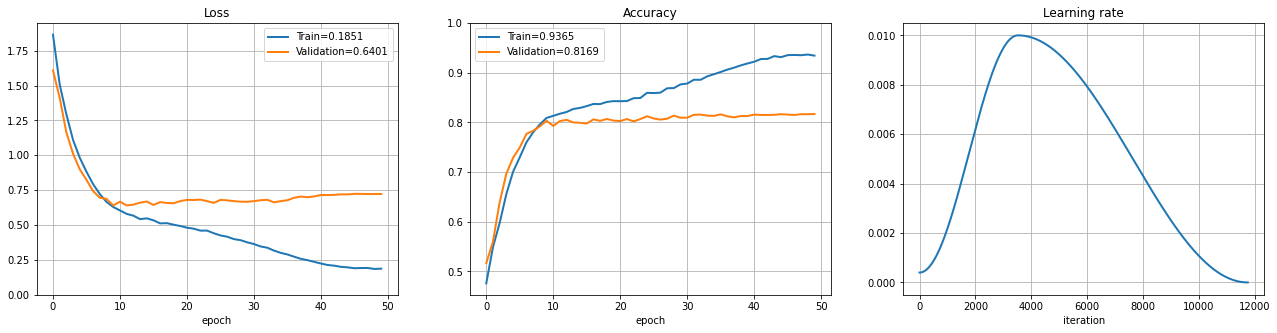

In [16]:
from DeepLearningFramework.Auxiliary import PlotHistory

PlotHistory(lHistory)
plt.show   ()

In [17]:
# With lr = 3e-5 the model ended with validation of ~0.6
# Decreasing the lr size helped to get a better val metric

In [18]:
# https://stackoverflow.com/questions/53290306/confusion-matrix-and-test-accuracy-for-pytorch-transfer-learning-tutorial

confusion_matrix = torch.zeros(nLabels, nLabels)
oModel.eval()
with torch.no_grad():
    for i, (inputs, classes) in enumerate(oTestDL):
        inputs = inputs.to(DEVICE)
        classes = classes.to(DEVICE)
        outputs = oModel(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

# Normalize the confusion_matrix
confusion_matrix/confusion_matrix.sum(1)

Text(146.5, 0.5, 'Predicted label')

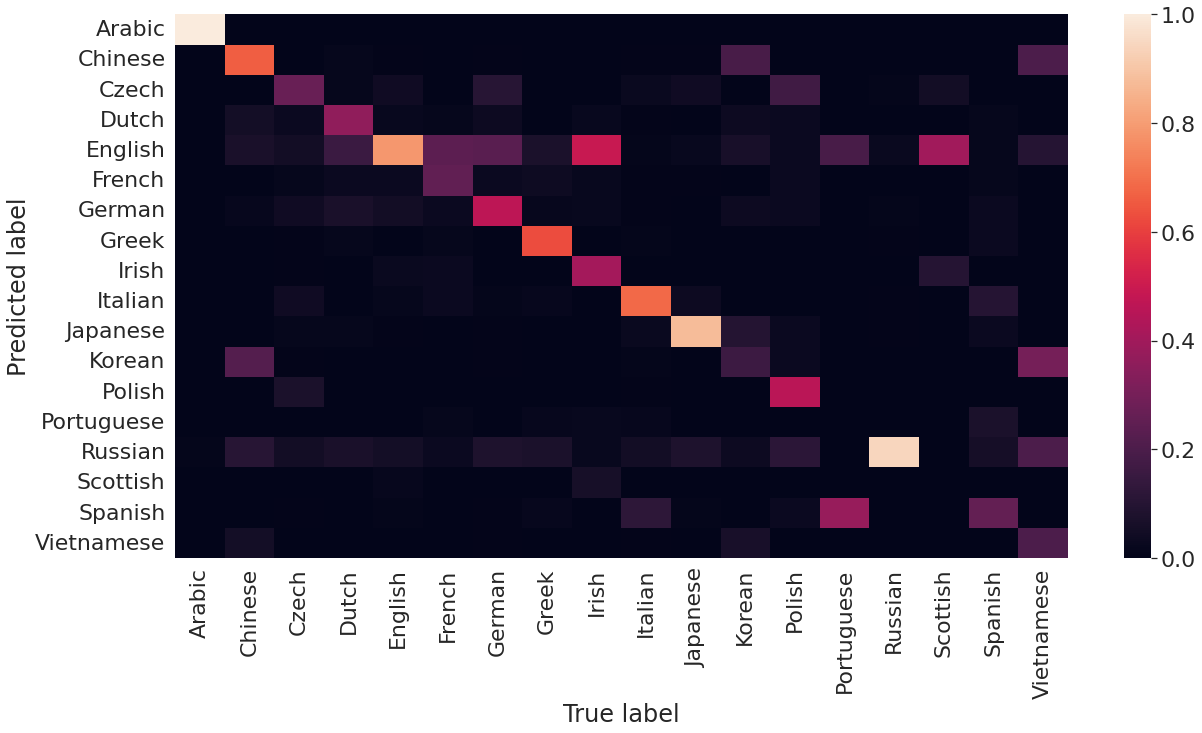

In [26]:
# https://datascience.stackexchange.com/questions/31746/how-to-include-labels-in-sns-heatmap

x_axis_labels = oLabelEncoder.classes_ # labels for x-axis
y_axis_labels = oLabelEncoder.classes_ # labels for y-axis

import seaborn as sns
from matplotlib.pyplot import figure
sns.set(font_scale=2)
plt.figure(figsize=(20, 10))
sns.heatmap(confusion_matrix, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel('True label')
plt.ylabel('Predicted label')

In [20]:
name  = 'Jones'
vName = Name2Tensor(name)

#oModel(vName) 

# error: 'Tensor' object has no attribute 'batch_sizes'
with torch.no_grad():
    oModel.eval()
    mPackNames = pack_sequence([vName], enforce_sorted=False)
    yhat = oModel(mPackNames) 